# Import dependencies

In [34]:
import os
os.environ['DDE_BACKEND'] = "pytorch"

import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import pyvista as pv
pv.set_jupyter_backend("static")

device = torch.device("cuda")

In [35]:
def show_solution(func):
    # Input: scalar "u" to be displayed
    grid = pv.UniformGrid(dimensions=(150, 200, 1),
                          origin=(-0.5, -0.5, 0),
                          spacing=(0.01, 0.01, 0.01))
    
    
    X = grid.points[:, 0:2]
    if isinstance(func, dde.Model) or isinstance(func, dde.nn.NN):
        u = func.predict(X)[:, 0]
    else:
        u = func(X)
        
    grid.point_data["u"] = u.flatten(order="F")
    
    plotter = pv.Plotter()
    plotter.add_mesh(grid)
    plotter.view_xy()
    plotter.show()

# Define governing equations

In [36]:
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [37]:
def u_func(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])


def v_func(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])


def p_func(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

In [38]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

# Define BC

In [39]:
def boundary_outflow(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [40]:
spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

boundary_condition_u = dde.icbc.DirichletBC(
    spatial_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatial_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_right_p = dde.icbc.DirichletBC(
    spatial_domain, p_func, boundary_outflow, component=2
)

data = dde.data.PDE(
    spatial_domain,
    pde,
    [boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    num_domain=2601,
    num_boundary=400,
    num_test=None,
)

# Network

In [41]:
net = dde.nn.FNN([2] + 4 * [50] + [3], "tanh", "Glorot normal")

In [42]:
model = dde.Model(data, net)

# Train Adam

In [43]:
ckpt_path = Path("models/onlyadam_10e/ckpt")
ckpt_path.mkdir(parents=True, exist_ok=True)

loss_path = Path("models/onlyadam_10e/loss")
loss_path.mkdir(parents=True, exist_ok=True)

In [31]:
# train with adam
model.compile("adam", lr=1e-3)
checkpointer = dde.callbacks.ModelCheckpoint(ckpt_path / "ckpt",
                                             verbose=1,
                                             save_better_only=True)

losshistory, train_state = model.train(iterations=10000, display_every=1000, callbacks=[checkpointer])

Compiling model...
'compile' took 0.000296 s

Training model...

0         [1.55e-03, 1.03e-01, 8.15e-04, 2.87e+00, 9.37e-02, 1.28e-01]    [1.55e-03, 1.03e-01, 8.15e-04, 2.87e+00, 9.37e-02, 1.28e-01]    []  
Epoch 1: train loss improved from inf to 3.20e+00, saving model to models/onlyadam_10e/ckpt/ckpt-1.pt ...

1000      [1.36e-02, 9.31e-03, 9.20e-03, 7.85e-02, 2.59e-02, 4.17e-04]    [1.36e-02, 9.31e-03, 9.20e-03, 7.85e-02, 2.59e-02, 4.17e-04]    []  
Epoch 1000: train loss improved from 3.20e+00 to 1.37e-01, saving model to models/onlyadam_10e/ckpt/ckpt-1000.pt ...

2000      [5.56e-03, 3.47e-03, 5.19e-03, 1.77e-02, 5.63e-03, 1.76e-04]    [5.56e-03, 3.47e-03, 5.19e-03, 1.77e-02, 5.63e-03, 1.76e-04]    []  
Epoch 2000: train loss improved from 1.37e-01 to 3.77e-02, saving model to models/onlyadam_10e/ckpt/ckpt-2000.pt ...

3000      [3.40e-03, 1.57e-03, 2.24e-03, 7.22e-03, 2.78e-03, 1.59e-04]    [3.40e-03, 1.57e-03, 2.24e-03, 7.22e-03, 2.78e-03, 1.59e-04]    []  
Epoch 3000: train lo

Saving loss history to models/onlyadam_10e/loss/loss ...


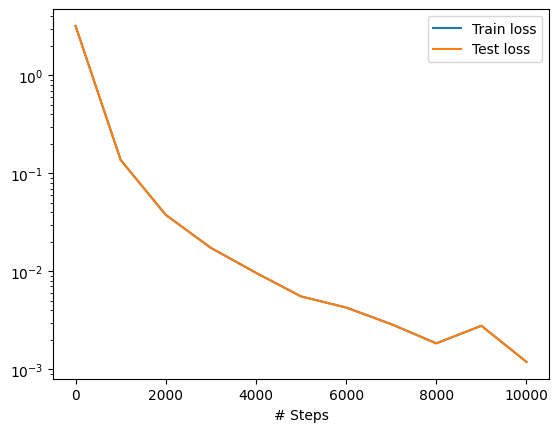

In [32]:
dde.utils.external.save_loss_history(loss_history=losshistory, fname=loss_path / "loss")
dde.utils.external.plot_loss_history(loss_history=losshistory)

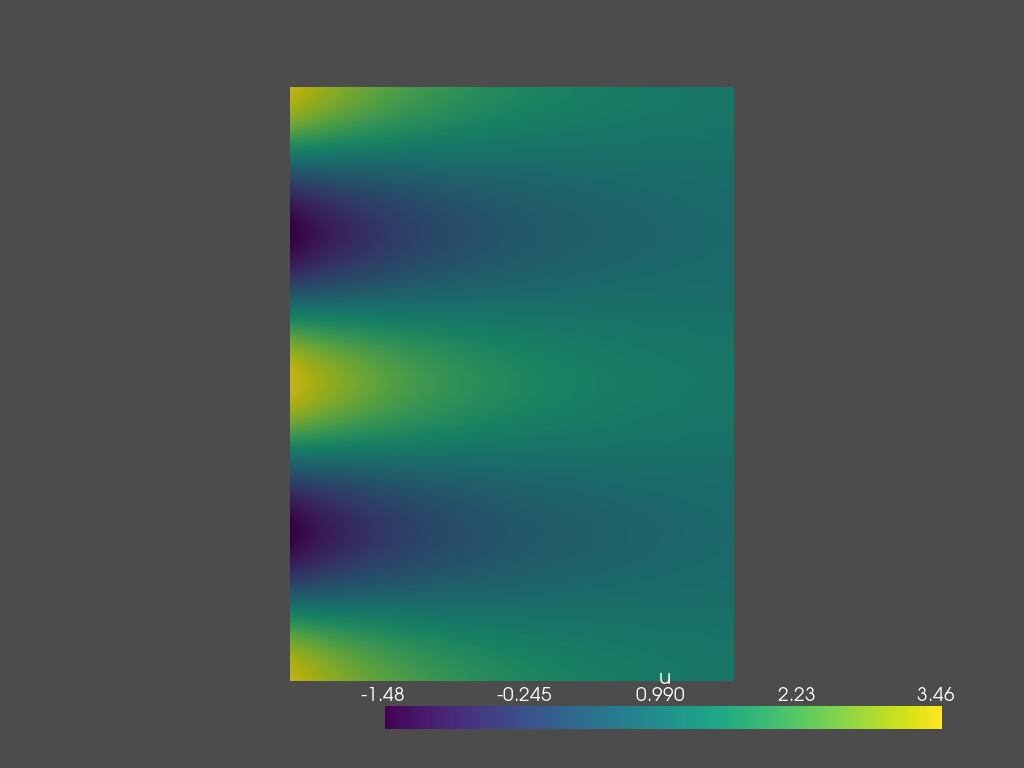

In [33]:
show_solution(model)

# Train L-BFGS

In [44]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000199 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.45e-02, 1.78e-02, 4.70e-02, 3.08e+00, 8.27e-02, 1.19e-01]    [1.45e-02, 1.78e-02, 4.70e-02, 3.08e+00, 8.27e-02, 1.19e-01]    []  
1000      [3.53e-04, 2.59e-04, 2.29e-04, 2.63e-04, 5.94e-05, 2.68e-05]    [3.53e-04, 2.59e-04, 2.29e-04, 2.63e-04, 5.94e-05, 2.68e-05]    []  
2000      [5.82e-05, 3.79e-05, 3.53e-05, 3.66e-05, 2.10e-05, 2.14e-06]    [5.82e-05, 3.79e-05, 3.53e-05, 3.66e-05, 2.10e-05, 2.14e-06]    []  
3000      [2.25e-05, 1.55e-05, 1.64e-05, 1.66e-05, 5.92e-06, 8.74e-07]    [2.25e-05, 1.55e-05, 1.64e-05, 1.66e-05, 5.92e-06, 8.74e-07]    []  
4000      [1.45e-05, 7.13e-06, 8.55e-06, 7.05e-06, 4.86e-06, 6.72e-07]    [1.45e-05, 7.13e-06, 8.55e-06, 7.05e-06, 4.86e-06, 6.72e-07]    []  
5000      [8.58e-06, 4.39e-06, 5.03e-06, 6.06e-06, 2.73e-06, 2.36e-07]

# Loss & Inference

In [18]:
X = spatial_domain.uniform_points(100000)

output = model.predict(X)
u_pred = output[:, 0]
v_pred = output[:, 1]
p_pred = output[:, 2]

u_exact = u_func(X).reshape(-1)
v_exact = v_func(X).reshape(-1)
p_exact = p_func(X).reshape(-1)

f = model.predict(X, operator=pde)

l2_difference_u = dde.metrics.l2_relative_error(u_exact, u_pred)
l2_difference_v = dde.metrics.l2_relative_error(v_exact, v_pred)
l2_difference_p = dde.metrics.l2_relative_error(p_exact, p_pred)
residual = np.mean(np.absolute(f))

print("Mean residual:", residual)
print("L2 relative error in u:", l2_difference_u)
print("L2 relative error in v:", l2_difference_v)
print("L2 relative error in p:", l2_difference_p)

Mean residual: 0.09201239
L2 relative error in u: 0.20258589
L2 relative error in v: 0.63643783
L2 relative error in p: 0.44821978
